# Dueling Double Deep Q-Network
Paper:
* DQN: https://arxiv.org/abs/1312.5602

In [3]:
import gymnasium as gym
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import ale_py

gym.register_envs(ale_py)
%matplotlib inline

## Environment

In [ ]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !wget -q https://raw.githubusercontent.com/laktionov/RL-course/2025/hw3/atari_wrappers.py
    !wget -q https://raw.githubusercontent.com/laktionov/RL-course/2025/hw3/utils.py
    !wget -q https://raw.githubusercontent.com/laktionov/RL-course/2025/hw3/framebuffer.py
    !pip -q install gymnasium[atari]==1.0.0
    !touch .setup_complete
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [4]:
ENV_NAME = "ALE/Breakout-v5"

Let's see what observations look like.

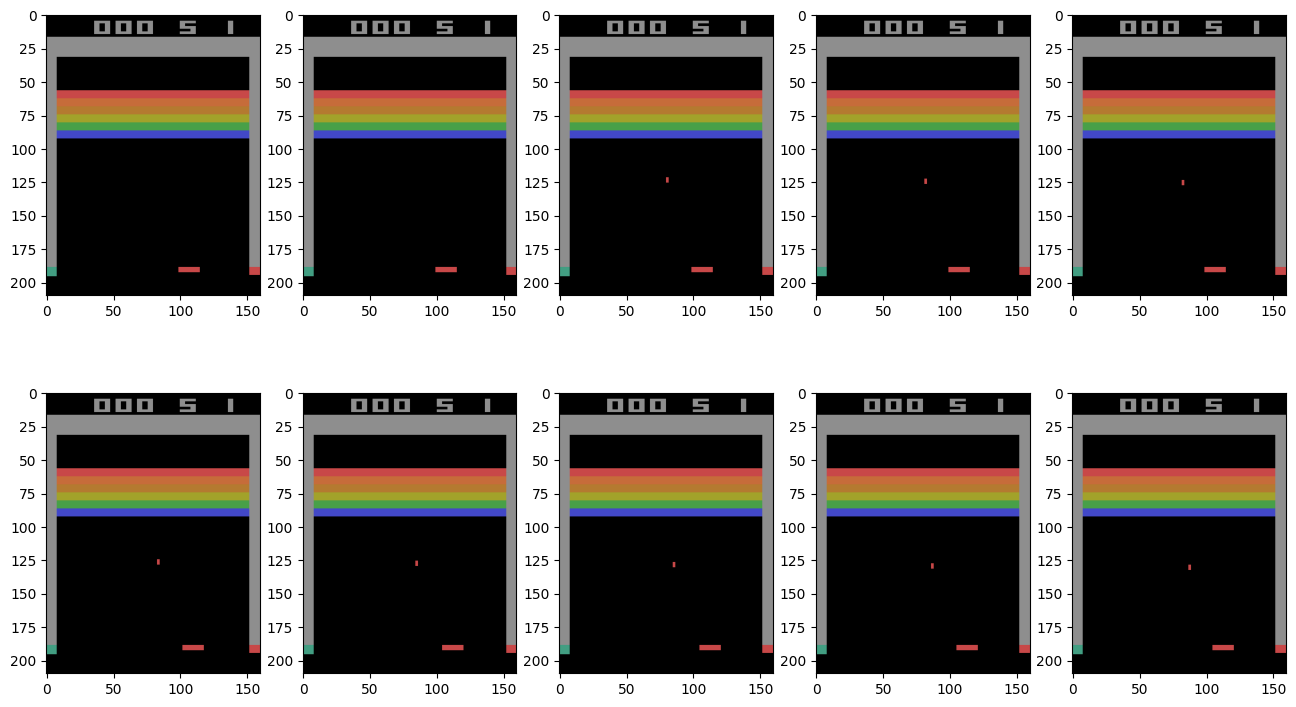

In [5]:
env = gym.make(ENV_NAME, render_mode="rgb_array",
               frameskip=1, repeat_action_probability=0.0)
env.reset()

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render())
        env.step(env.action_space.sample())
plt.show()

### Processing game image

Raw atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn them.

We can thus save a lot of time by preprocessing game image, including
* Resizing to a smaller shape, 64 x 64
* Converting to grayscale
* Cropping irrelevant image parts (top, bottom and edges)

In [7]:
from gymnasium import ObservationWrapper
from gymnasium.spaces import Box
import cv2


class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)

    def _to_gray_scale(self, rgb, channel_weights=[0.8, 0.1, 0.1]):
        return np.dot(rgb[...,:3], channel_weights)[None, :, :]

    def observation(self, img):
        img = img[31:-17, 7:-8] # crop
        img = cv2.resize(img, (64, 64)) # resize
        img = self._to_gray_scale(img) # grayscale
        img = img.astype(np.float32) / 256 # float
        return img

### Wrapping

In [9]:
import atari_wrappers

def PrimaryAtariWrap(env, clip_rewards=True):
    env = atari_wrappers.MaxAndSkipEnv(env, skip=4)
    env = atari_wrappers.EpisodicLifeEnv(env)
    env = atari_wrappers.FireResetEnv(env)
    if clip_rewards:
        env = atari_wrappers.ClipRewardEnv(env)
    env = PreprocessAtariObs(env)
    return env

# Frame Buffer

Our agent can only process one observation at a time, so we gotta make sure it contains enough information to find optimal actions. For instance, agent has to react to moving objects so he must be able to measure object's velocity. To do so, we introduce a buffer that stores 4 last images.

In [10]:
from framebuffer import FrameBuffer
import utils

def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME, render_mode="rgb_array")
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape
n_actions, state_shape

(4, (4, 64, 64))

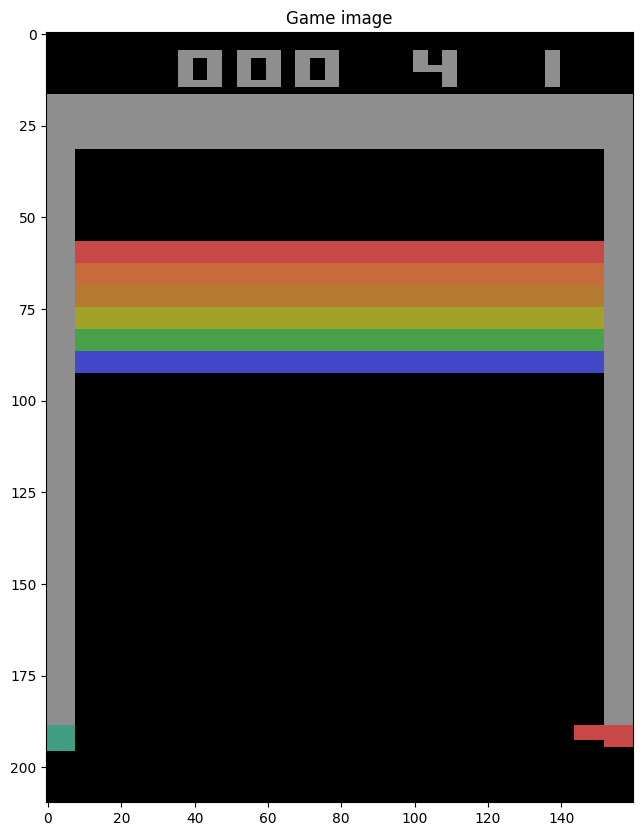

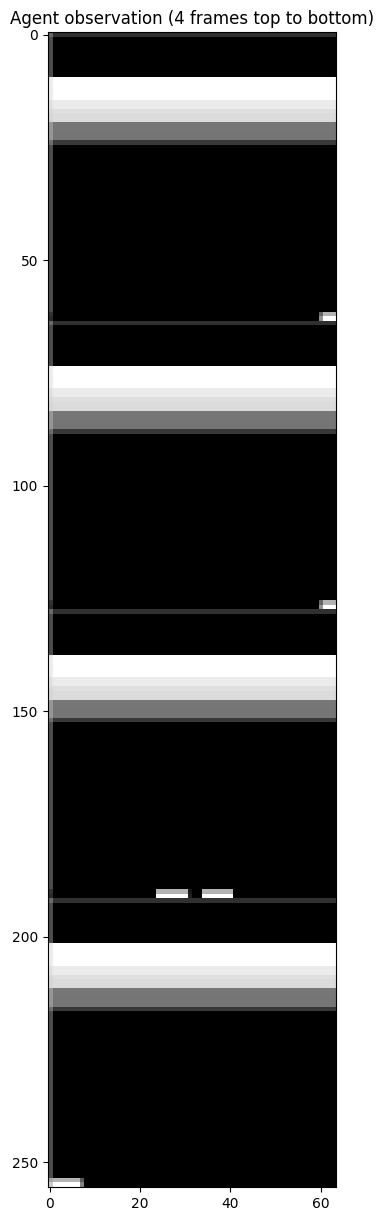

In [11]:
for _ in range(12):
    obs, _, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render())
plt.show()

plt.figure(figsize=[15, 15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(utils.img_by_obs(obs, state_shape), cmap='gray')
plt.show()

## Dueling DDQN 
Paper: https://arxiv.org/pdf/1511.06581.pdf

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
def conv2d_size_out(size, kernel_size, stride):
    return (size - (kernel_size - 1) - 1) // stride  + 1

In [14]:
class DuelingNetwork(nn.Module):
    
    def __init__(self, n_actions, inp_size, hidden_size) -> None:
        super().__init__()
        self.n_actions = n_actions
        self.inp_size = inp_size
        self.hidden_size = hidden_size
        self.conv = nn.Sequential(nn.Conv2d(in_channels=self.inp_size[0], out_channels=16, kernel_size=3, stride=2),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
                                  nn.ReLU())

        conv_out_size = self.conv(torch.zeros(1, *self.inp_size)).flatten().size()[0]
        self.fc_v = nn.Sequential(nn.Linear(conv_out_size, 256),
                                  nn.ReLU(),
                                  nn.Linear(256, 1))

        self.fc_a = nn.Sequential(nn.Linear(conv_out_size, 256),
                                  nn.ReLU(),
                                  nn.Linear(256, self.n_actions))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        conv_x = self.conv(x).flatten(start_dim=1, end_dim=-1)
        v = self.fc_v(conv_x)
        a = self.fc_a(conv_x)
        return v + a - a.mean(dim=1, keepdim=True)

In [16]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        self.network = DuelingNetwork(n_actions, inp_size=state_shape, hidden_size=1).to(device)

    def forward(self, state_t):
        state_t = state_t.to(device)
        return self.network(state_t)

    @torch.inference_mode()
    def get_qvalues(self, states: np.ndarray) -> np.ndarray:
    
        states = torch.tensor(states).to(device)
        q_values = self.network(states).cpu()
        return np.array(q_values)

    def sample_actions_by_qvalues(self, qvalues: np.ndarray, greedy: bool = False) -> np.ndarray:
        batch_size, n_actions = qvalues.shape
        greedy_actions = np.argmax(qvalues, axis=1) 
        random_actions = np.random.choice(n_actions, size=batch_size)

        if greedy == True:
            return greedy_actions
        else:
            if np.random.random() > self.epsilon:
                return greedy_actions
            else:
                return random_actions

            actions = np.random.choice(n_actions, size=batch_size)
        return actions

    def sample_actions(self, states: np.ndarray, greedy: bool = False) -> np.ndarray:
        qvalues = self.get_qvalues(states)
        return self.sample_actions_by_qvalues(qvalues, greedy=greedy)

In [17]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

Now let's try out our agent to see if it raises any errors.

In [18]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s, _ = env.reset()
        reward = 0
        for _ in range(t_max):

            action = agent.sample_actions([s], greedy=greedy)[0]
            s, r, terminated, truncated, _ = env.step(action)
            reward += r
            if terminated or truncated:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [19]:
evaluate(env, agent, n_games=10)

<ipython-input-16-a4559ac1d878>:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.tensor(states).to(device)


0.6

## Experience Replay

In [20]:
from collections import deque

class ReplayBuffer:
    def __init__(self, size):
        self.storage = deque()
        self.size = size

    def __len__(self):
        return len(self.storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)
        self.storage.append(data)
        if len(self)> self.size:
            self.storage.popleft()

    def sample(self, batch_size):
        ind = np.random.choice(len(self.storage), size = batch_size, replace = False)
        states = np.stack([self.storage[i][0] for i in ind])
        actions = np.stack([self.storage[i][1] for i in ind])
        rewards = np.stack([self.storage[i][2] for i in ind])
        next_states = np.stack([self.storage[i][3] for i in ind])
        is_done = np.stack([self.storage[i][4] for i in ind])

        return states, actions, rewards, next_states, is_done

In [22]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    s = initial_state
    sum_rewards = 0
    for _ in range(n_steps):
        action = agent.sample_actions([s])[0]
        next_s, r, terminated, truncated, _ = env.step(action)
        exp_replay.add(s, action, r, next_s, terminated)
        sum_rewards += r
        s = next_s
        if terminated or truncated:
            s, _ = env.reset()

    return sum_rewards, s

# Target networks

We also employ the so called "target network" - a copy of neural network weights to be used for reference Q-values:
The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every so often.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$


In [24]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

# Double DQN (1 point)

To prevent overestimation bias we also decouple action selection from action evaluation using agent's network and target network respectively.

$$ Q_{reference}(s,a) = r(s, a) + \gamma \cdot Q_{target}(s', argmax_{a'} Q_{
  \theta}(s', a')) $$

## Learning with double Q-learning

Q-learning TD error:

$$ L = { 1 \over N} \sum_{(s, a)} [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

#### 1-step Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot Q_{target}(s', argmax_{a'} Q_{\theta}(s', a')) $$

Where
* $Q_{target}(s',a')$ denotes q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

In [25]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_agent,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):
   
    states = torch.tensor(states, device=device, dtype=torch.float)    
    actions = torch.tensor(actions, device=device, dtype=torch.long)    
    rewards = torch.tensor(rewards, device=device, dtype=torch.float) 
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float
    )  
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)

    # compute q-values for all actions in next states
    with torch.no_grad():
        predicted_next_qvalues = agent(next_states)
        target_predicted_next_qvalues = target_agent(next_states)

    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[torch.arange(predicted_qvalues.shape[0]) , actions]

    # compute V*(next_states) using predicted next q-values
    greedy_actions = agent.sample_actions(next_states, greedy=True)
    next_state_values= target_predicted_next_qvalues[torch.arange(target_predicted_next_qvalues.shape[0]) , greedy_actions]#<YOUR_CODE>
   
    target_qvalues_for_actions = rewards + is_not_done * gamma * next_state_values

    # mean squared error loss to minimize
    loss = torch.mean((target_qvalues_for_actions - predicted_qvalues_for_actions)**2)
    return loss

## Main loop 

In [28]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [29]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [30]:
env = make_env(seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state, _ = env.reset()

agent = DQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_shape, n_actions).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [ ]:
exp_replay = ReplayBuffer(10**5)
for i in range(100):
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

10000


In [34]:
timesteps_per_epoch = 1
batch_size = 32
total_steps = 3 * 10**6
decay_steps = 10**6

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 50
refresh_target_network_freq = 5000
eval_freq = 5000

max_grad_norm = 50

n_lives = 5

In [ ]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []

buffer size = 100000, epsilon = 0.39700


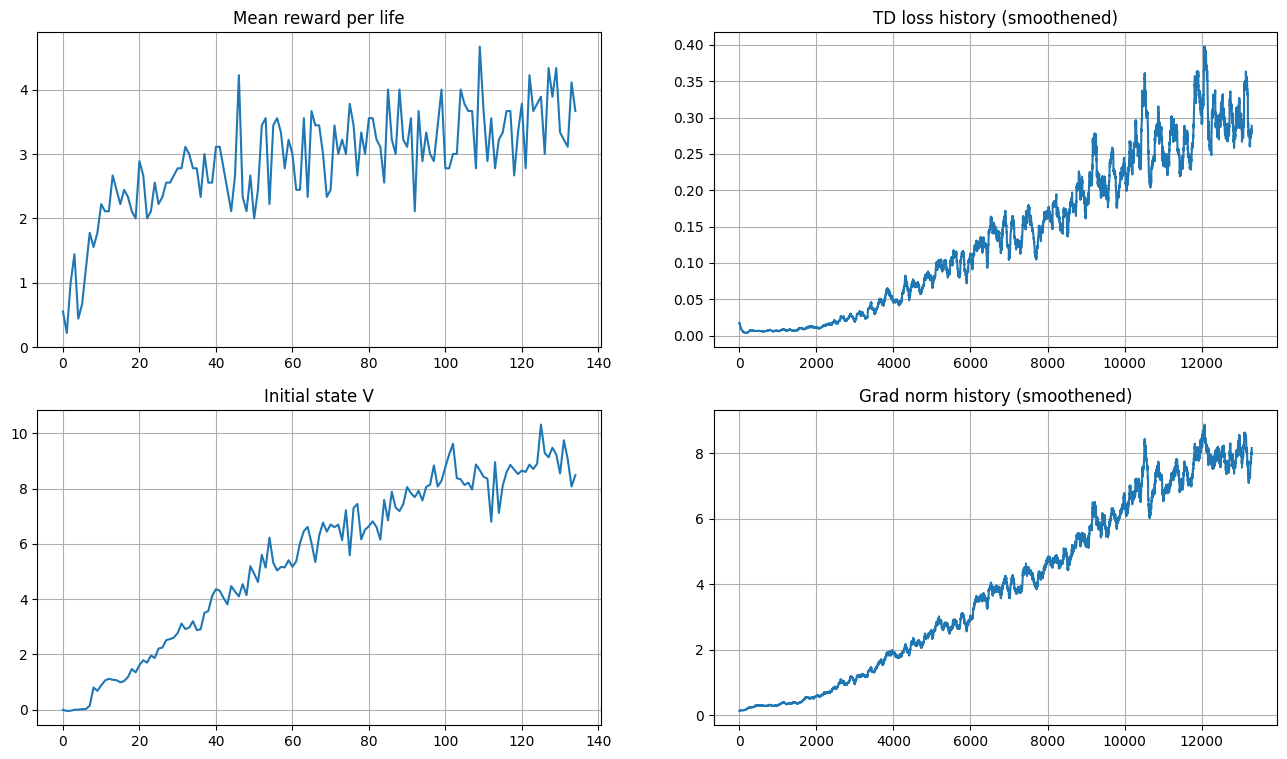

 22%|██▏       | 671103/3000001 [3:36:23<12:30:54, 51.69it/s]Exception ignored in: <generator object tqdm.__iter__ at 0x7d2e10b8c500>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/tqdm/std.py", line 1196, in __iter__
  File "/usr/local/lib/python3.11/dist-packages/tqdm/std.py", line 1302, in close
    self.display(pos=0)
  File "/usr/local/lib/python3.11/dist-packages/tqdm/std.py", line 1495, in display
    self.sp(self.__str__() if msg is None else msg)
  File "/usr/local/lib/python3.11/dist-packages/tqdm/std.py", line 459, in print_status
    fp_write('\r' + s + (' ' * max(last_len[0] - len_s, 0)))
  File "/usr/local/lib/python3.11/dist-packages/tqdm/std.py", line 453, in fp_write
    fp_flush()
  File "/usr/local/lib/python3.11/dist-packages/tqdm/utils.py", line 196, in inner
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/iostream.py", line 486, in flush
    self.pub_thr

KeyboardInterrupt: 

In [ ]:
state, _ = env.reset()
for step in trange(total_steps + 1):
    agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)
    # play
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)
    # train
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)

    loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                          agent, target_network,
                          gamma=0.99)

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm.cpu().item())

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
            target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        mean_rw_history.append(evaluate(
            make_env(clip_rewards=True, seed=step), agent, n_games=3 * 3, greedy=True)
        )
        initial_state_q_values = agent.get_qvalues(
            [make_env(seed=step).reset()[0]]
        )
        initial_state_v_history.append(np.max(initial_state_q_values))

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 9])

        plt.subplot(2, 2, 1)
        plt.title("Mean reward per life")
        plt.plot(mean_rw_history)
        plt.grid()

        plt.subplot(2, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Initial state V")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("Grad norm history (smoothened)")
        plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()
        plt.show()

In [37]:
final_score = evaluate(
  make_env(clip_rewards=False, seed=9),
    agent, n_games=30, greedy=True, t_max=10 * 1000
) * n_lives
print('final score:', final_score)
assert final_score > 20, 'not as cool as DQN can'
print('Cool!')

final score: 22.333333333333336
Cool!
